# ⚡️ Energy-Based Models

In this notebook, we'll walk through the steps required to train your own Energy Based Model to predict the distribution of a demo dataset

The code is adapted from the excellent ['Deep Energy-Based Generative Models' tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial8/Deep_Energy_Models.html) created by Phillip Lippe.

In [19]:
%load_ext autoreload
%autoreload 2

import numpy as np

import tensorflow as tf
from tensorflow.keras import (
    datasets,
    layers,
    models,
    optimizers,
    activations,
    metrics,
    callbacks,
)

from notebooks.utils import display, sample_batch
import random

%mkdir output
%mkdir notebooks
print("DON'T FORGET TO upload utils.py into notebooks folder")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
mkdir: cannot create directory ‘output’: File exists
mkdir: cannot create directory ‘notebooks’: File exists
DON'T FORGET TO upload utils.py into notebooks folder


## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 1
STEP_SIZE = 10
STEPS = 60
NOISE = 0.005
ALPHA = 0.1
GRADIENT_CLIP = 0.03
BATCH_SIZE = 128
BUFFER_SIZE = 8192
LEARNING_RATE = 0.0001
EPOCHS = 60
LOAD_MODEL = False

In [4]:
# Load the data
(x_train, _), (x_test, _) = datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# Preprocess the data


def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = (imgs.astype("float32") - 127.5) / 127.5
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=-1.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [6]:
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(BATCH_SIZE)
x_test = tf.data.Dataset.from_tensor_slices(x_test).batch(BATCH_SIZE)

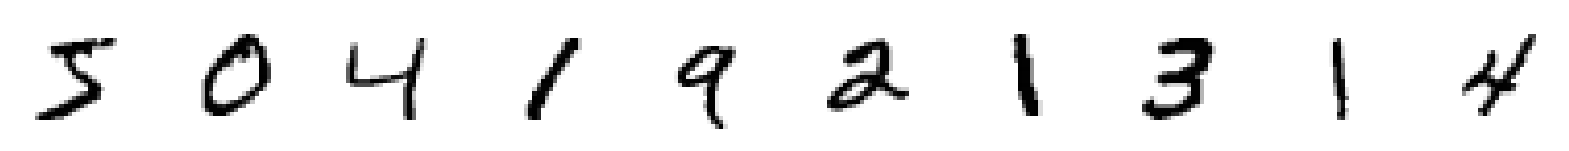

In [20]:
# Show some items of clothing from the training set
train_sample = sample_batch(x_train)
display(train_sample)

## 2. Build the EBM network <a name="train"></a>

In [21]:
ebm_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(
    16, kernel_size=5, strides=2, padding="same", activation=activations.swish
)(ebm_input)
x = layers.Conv2D(
    32, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Conv2D(
    64, kernel_size=3, strides=2, padding="same", activation=activations.swish
)(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation=activations.swish)(x)
ebm_output = layers.Dense(1)(x)
model = models.Model(ebm_input, ebm_output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        416       
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 2, 2, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                1644

In [22]:
if LOAD_MODEL:
    model.load_weights("./models/model.h5")

## 2. Set up a Langevin sampler function <a name="sampler"></a>

In [23]:
# Function to generate samples using Langevin Dynamics
def generate_samples(
    model, inp_imgs, steps, step_size, noise, return_img_per_step=False
):
    imgs_per_step = []
    for _ in range(steps):
        inp_imgs += tf.random.normal(inp_imgs.shape, mean=0, stddev=noise)
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        with tf.GradientTape() as tape:
            tape.watch(inp_imgs)
            out_score = model(inp_imgs)
        grads = tape.gradient(out_score, inp_imgs)
        grads = tf.clip_by_value(grads, -GRADIENT_CLIP, GRADIENT_CLIP)
        inp_imgs += step_size * grads
        inp_imgs = tf.clip_by_value(inp_imgs, -1.0, 1.0)
        if return_img_per_step:
            imgs_per_step.append(inp_imgs)
    if return_img_per_step:
        return tf.stack(imgs_per_step, axis=0)
    else:
        return inp_imgs

## 3. Set up a buffer to store examples <a name="buffer"></a>

In [24]:
class Buffer:
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.examples = [
            tf.random.uniform(shape=(1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2
            - 1
            for _ in range(BATCH_SIZE)
        ]

    def sample_new_exmps(self, steps, step_size, noise):
        n_new = np.random.binomial(BATCH_SIZE, 0.05)
        rand_imgs = (
            tf.random.uniform((n_new, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
        )
        old_imgs = tf.concat(
            random.choices(self.examples, k=BATCH_SIZE - n_new), axis=0
        )
        inp_imgs = tf.concat([rand_imgs, old_imgs], axis=0)
        inp_imgs = generate_samples(
            self.model, inp_imgs, steps=steps, step_size=step_size, noise=noise
        )
        self.examples = tf.split(inp_imgs, BATCH_SIZE, axis=0) + self.examples
        self.examples = self.examples[:BUFFER_SIZE]
        return inp_imgs

In [25]:
class EBM(models.Model):
    def __init__(self):
        super(EBM, self).__init__()
        self.model = model
        self.buffer = Buffer(self.model)
        self.alpha = ALPHA
        self.loss_metric = metrics.Mean(name="loss")
        self.reg_loss_metric = metrics.Mean(name="reg")
        self.cdiv_loss_metric = metrics.Mean(name="cdiv")
        self.real_out_metric = metrics.Mean(name="real")
        self.fake_out_metric = metrics.Mean(name="fake")

    @property
    def metrics(self):
        return [
            self.loss_metric,
            self.reg_loss_metric,
            self.cdiv_loss_metric,
            self.real_out_metric,
            self.fake_out_metric,
        ]

    def train_step(self, real_imgs):
        real_imgs += tf.random.normal(
            shape=tf.shape(real_imgs), mean=0, stddev=NOISE
        )
        real_imgs = tf.clip_by_value(real_imgs, -1.0, 1.0)
        fake_imgs = self.buffer.sample_new_exmps(
            steps=STEPS, step_size=STEP_SIZE, noise=NOISE
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        with tf.GradientTape() as training_tape:
            real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
            cdiv_loss = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
                real_out, axis=0
            )
            reg_loss = self.alpha * tf.reduce_mean(
                real_out**2 + fake_out**2, axis=0
            )
            loss = cdiv_loss + reg_loss
        grads = training_tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )
        self.loss_metric.update_state(loss)
        self.reg_loss_metric.update_state(reg_loss)
        self.cdiv_loss_metric.update_state(cdiv_loss)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, real_imgs):
        batch_size = real_imgs.shape[0]
        fake_imgs = (
            tf.random.uniform((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
            * 2
            - 1
        )
        inp_imgs = tf.concat([real_imgs, fake_imgs], axis=0)
        real_out, fake_out = tf.split(self.model(inp_imgs), 2, axis=0)
        cdiv = tf.reduce_mean(fake_out, axis=0) - tf.reduce_mean(
            real_out, axis=0
        )
        self.cdiv_loss_metric.update_state(cdiv)
        self.real_out_metric.update_state(tf.reduce_mean(real_out, axis=0))
        self.fake_out_metric.update_state(tf.reduce_mean(fake_out, axis=0))
        return {m.name: m.result() for m in self.metrics[2:]}

In [26]:
ebm = EBM()

## 3. Train the EBM network <a name="train"></a>

In [27]:
# Compile and train the model
ebm.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE), run_eagerly=True
)

In [28]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        start_imgs = (
            np.random.uniform(
                size=(self.num_img, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
            )
            * 2
            - 1
        )
        generated_images = generate_samples(
            ebm.model,
            start_imgs,
            steps=1000,
            step_size=STEP_SIZE,
            noise=NOISE,
            return_img_per_step=False,
        )
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

        example_images = tf.concat(
            random.choices(ebm.buffer.examples, k=10), axis=0
        )
        example_images = example_images.numpy()
        display(
            example_images, save_to="./output/example_img_%03d.png" % (epoch)
        )


image_generator_callback = ImageGenerator(num_img=10)

In [29]:
class SaveModel(callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        model.save_weights("./models/model.h5")


save_model_callback = SaveModel()

Epoch 1/60
469/469 [==============================] - ETA: 0s - loss: -0.0364 - reg: 0.0127 - cdiv: -0.0491 - real: 0.2053 - fake: 0.1562
Saved to ./output/generated_img_000.png


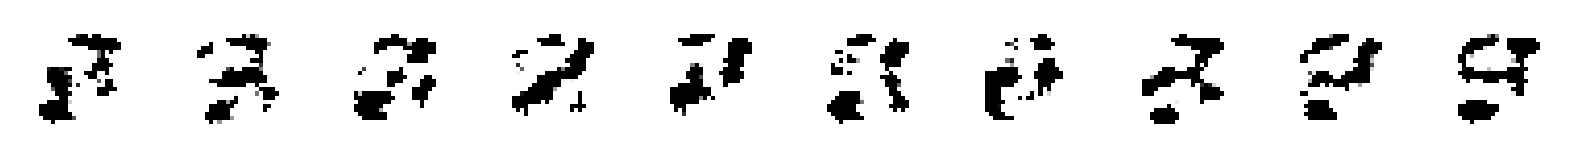


Saved to ./output/example_img_000.png


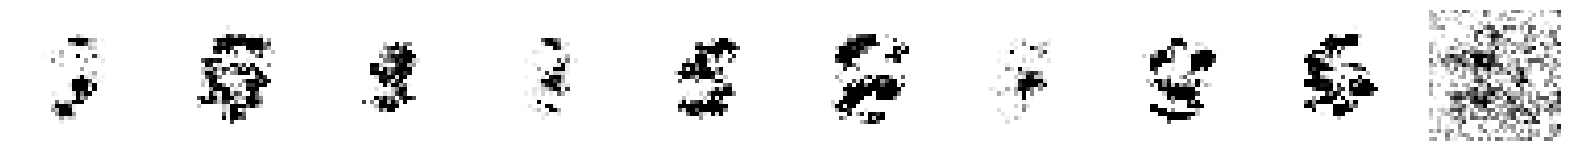

469/469 [==============================] - 562s 1s/step - loss: -0.0364 - reg: 0.0127 - cdiv: -0.0491 - real: 0.2053 - fake: 0.1562 - val_cdiv: -1.4714 - val_real: -0.0223 - val_fake: -1.4937
Epoch 2/60
469/469 [==============================] - ETA: 0s - loss: -0.0018 - reg: 0.0020 - cdiv: -0.0038 - real: 0.0090 - fake: 0.0052
Saved to ./output/generated_img_001.png


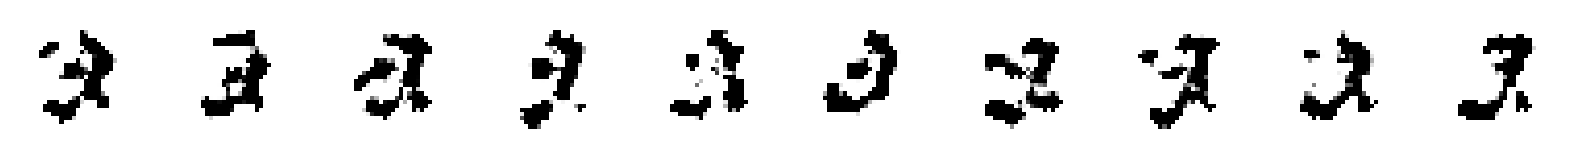


Saved to ./output/example_img_001.png


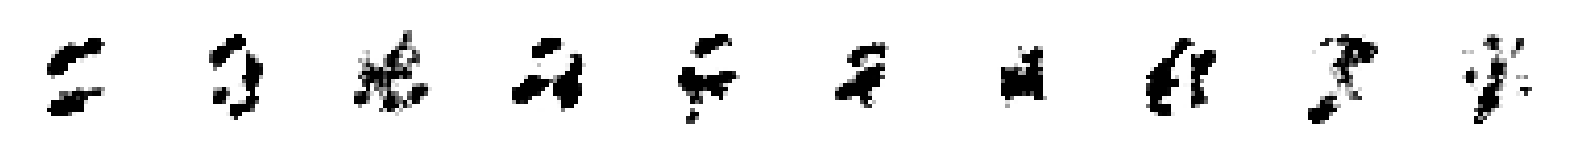

469/469 [==============================] - 566s 1s/step - loss: -0.0018 - reg: 0.0020 - cdiv: -0.0038 - real: 0.0090 - fake: 0.0052 - val_cdiv: -1.6476 - val_real: -0.0920 - val_fake: -1.7396
Epoch 3/60
469/469 [==============================] - ETA: 0s - loss: -0.0015 - reg: 0.0012 - cdiv: -0.0026 - real: 0.0046 - fake: 0.0020
Saved to ./output/generated_img_002.png


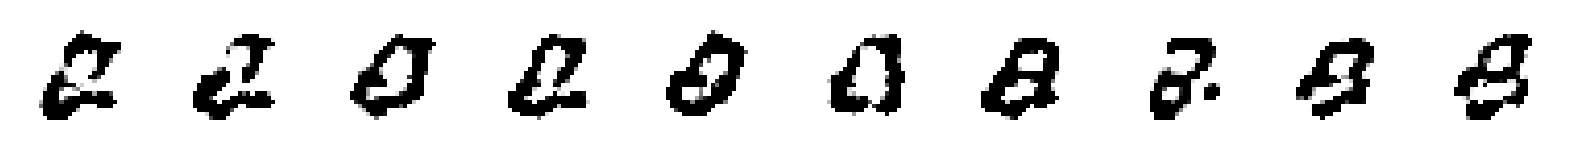


Saved to ./output/example_img_002.png


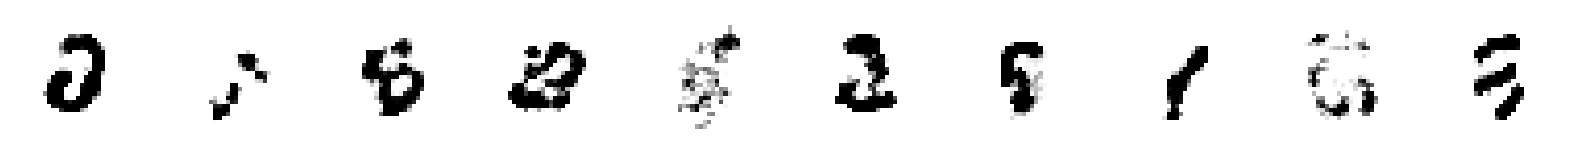

469/469 [==============================] - 565s 1s/step - loss: -0.0015 - reg: 0.0012 - cdiv: -0.0026 - real: 0.0046 - fake: 0.0020 - val_cdiv: -2.0434 - val_real: -0.0150 - val_fake: -2.0584
Epoch 4/60
469/469 [==============================] - ETA: 0s - loss: 2.8039e-04 - reg: 6.0187e-04 - cdiv: -3.2149e-04 - real: 0.0025 - fake: 0.0022
Saved to ./output/generated_img_003.png


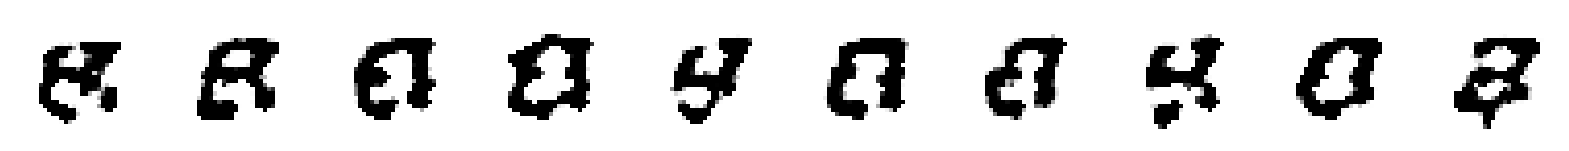


Saved to ./output/example_img_003.png


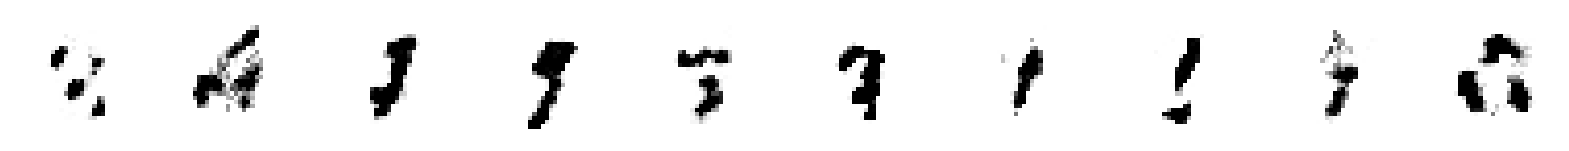

469/469 [==============================] - 560s 1s/step - loss: 2.8039e-04 - reg: 6.0187e-04 - cdiv: -3.2149e-04 - real: 0.0025 - fake: 0.0022 - val_cdiv: -2.2487 - val_real: -0.0235 - val_fake: -2.2722
Epoch 5/60
469/469 [==============================] - ETA: 0s - loss: 9.5952e-04 - reg: 3.1935e-04 - cdiv: 6.4017e-04 - real: 8.6643e-04 - fake: 0.0015
Saved to ./output/generated_img_004.png


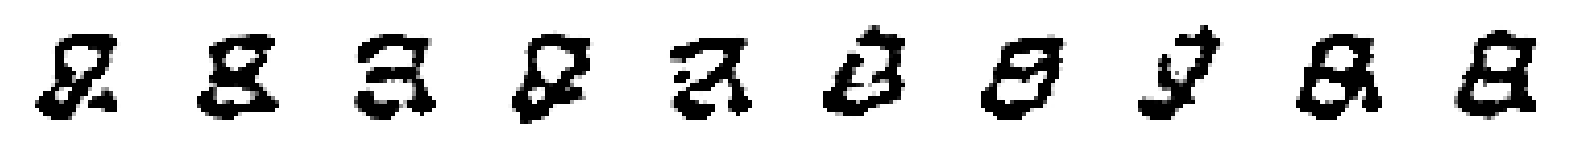


Saved to ./output/example_img_004.png


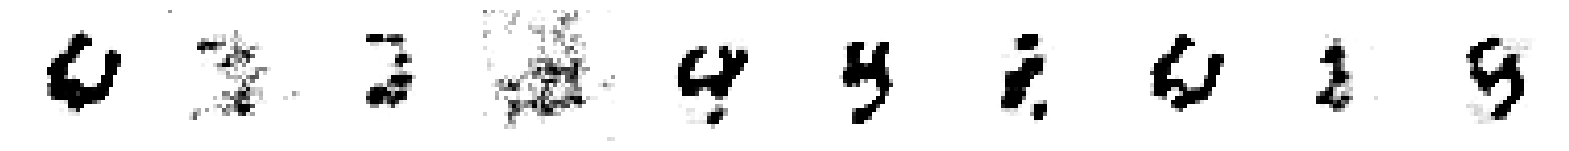

469/469 [==============================] - 556s 1s/step - loss: 9.5952e-04 - reg: 3.1935e-04 - cdiv: 6.4017e-04 - real: 8.6643e-04 - fake: 0.0015 - val_cdiv: -2.3944 - val_real: -0.0206 - val_fake: -2.4149
Epoch 6/60
469/469 [==============================] - ETA: 0s - loss: 7.1104e-04 - reg: 2.7038e-04 - cdiv: 4.4066e-04 - real: 0.0014 - fake: 0.0018
Saved to ./output/generated_img_005.png


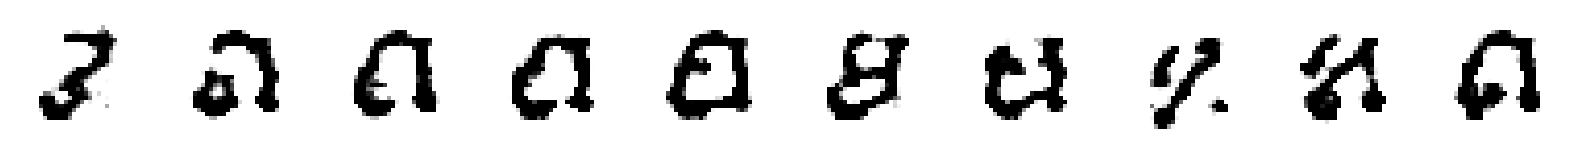


Saved to ./output/example_img_005.png


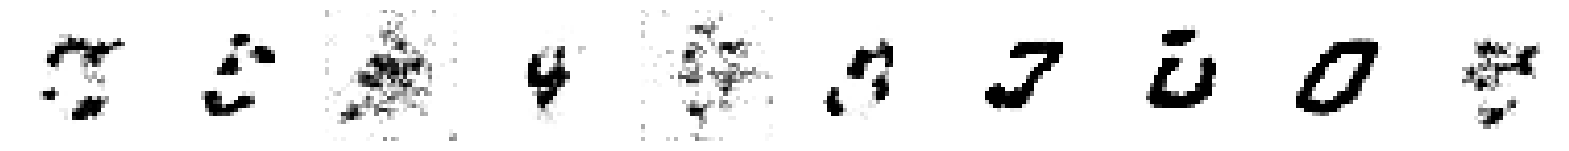

469/469 [==============================] - 560s 1s/step - loss: 7.1104e-04 - reg: 2.7038e-04 - cdiv: 4.4066e-04 - real: 0.0014 - fake: 0.0018 - val_cdiv: -2.6335 - val_real: -0.0119 - val_fake: -2.6454
Epoch 7/60
469/469 [==============================] - ETA: 0s - loss: 2.5070e-04 - reg: 2.6033e-04 - cdiv: -9.6276e-06 - real: 0.0017 - fake: 0.0017
Saved to ./output/generated_img_006.png


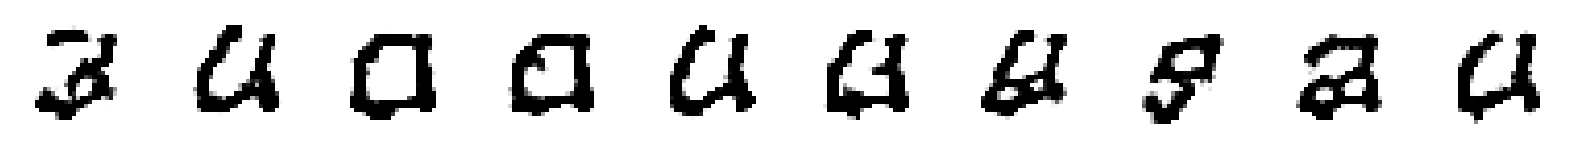


Saved to ./output/example_img_006.png


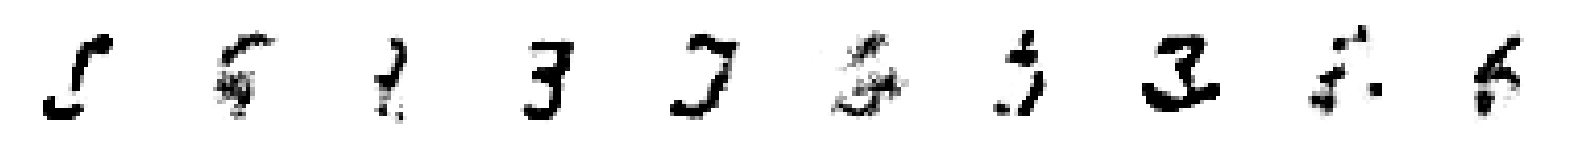

469/469 [==============================] - 565s 1s/step - loss: 2.5070e-04 - reg: 2.6033e-04 - cdiv: -9.6276e-06 - real: 0.0017 - fake: 0.0017 - val_cdiv: -2.9244 - val_real: -0.0281 - val_fake: -2.9524
Epoch 8/60
469/469 [==============================] - ETA: 0s - loss: 4.1073e-04 - reg: 3.3058e-04 - cdiv: 8.0141e-05 - real: 0.0012 - fake: 0.0013
Saved to ./output/generated_img_007.png


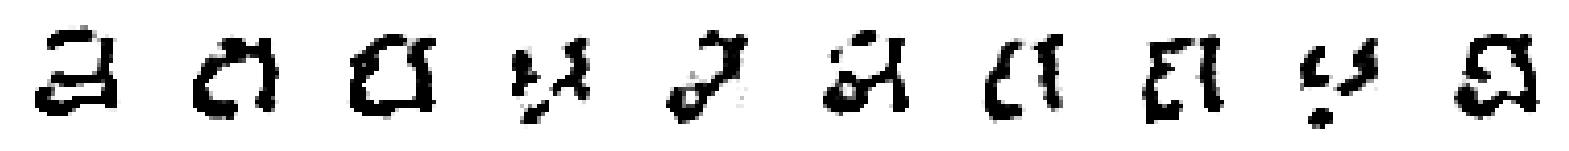


Saved to ./output/example_img_007.png


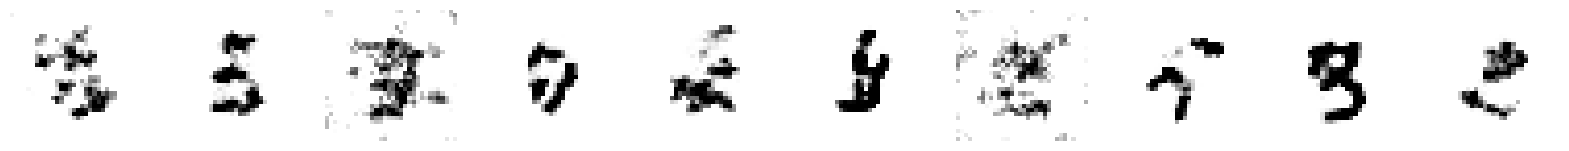

469/469 [==============================] - 556s 1s/step - loss: 4.1073e-04 - reg: 3.3058e-04 - cdiv: 8.0141e-05 - real: 0.0012 - fake: 0.0013 - val_cdiv: -3.2194 - val_real: 0.0062 - val_fake: -3.2132
Epoch 9/60
469/469 [==============================] - ETA: 0s - loss: 4.2655e-04 - reg: 3.0184e-04 - cdiv: 1.2471e-04 - real: 0.0012 - fake: 0.0013
Saved to ./output/generated_img_008.png


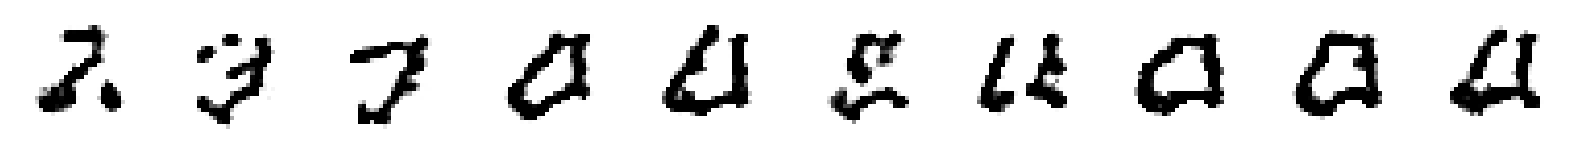


Saved to ./output/example_img_008.png


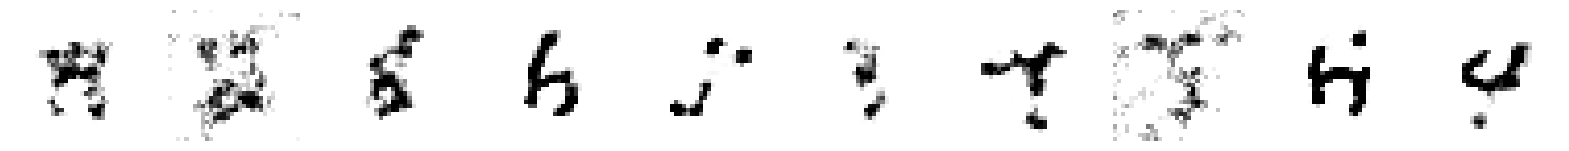

469/469 [==============================] - 560s 1s/step - loss: 4.2655e-04 - reg: 3.0184e-04 - cdiv: 1.2471e-04 - real: 0.0012 - fake: 0.0013 - val_cdiv: -3.5130 - val_real: 0.0485 - val_fake: -3.4644
Epoch 10/60
469/469 [==============================] - ETA: 0s - loss: 1.8076e-04 - reg: 2.6473e-04 - cdiv: -8.3971e-05 - real: 0.0016 - fake: 0.0015
Saved to ./output/generated_img_009.png


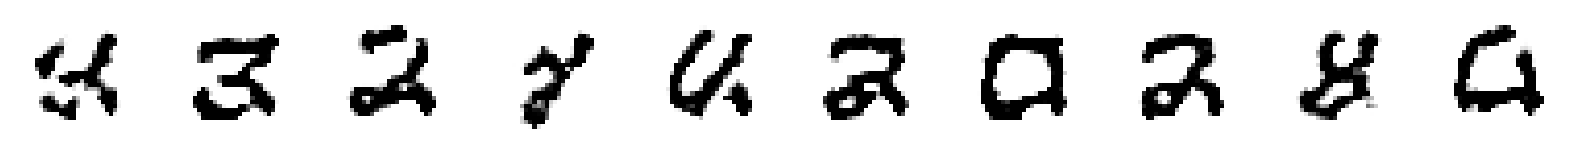


Saved to ./output/example_img_009.png


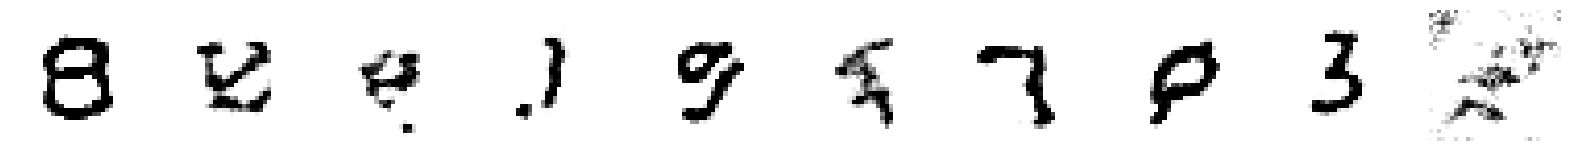

469/469 [==============================] - 560s 1s/step - loss: 1.8076e-04 - reg: 2.6473e-04 - cdiv: -8.3971e-05 - real: 0.0016 - fake: 0.0015 - val_cdiv: -3.7505 - val_real: 0.0033 - val_fake: -3.7473
Epoch 11/60
469/469 [==============================] - ETA: 0s - loss: 2.7000e-04 - reg: 2.9776e-04 - cdiv: -2.7762e-05 - real: 0.0011 - fake: 0.0011    
Saved to ./output/generated_img_010.png


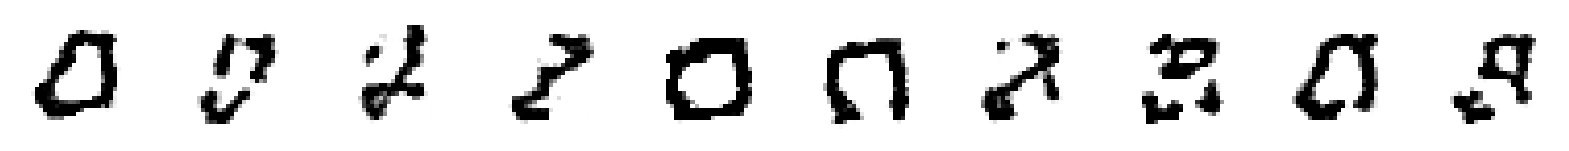


Saved to ./output/example_img_010.png


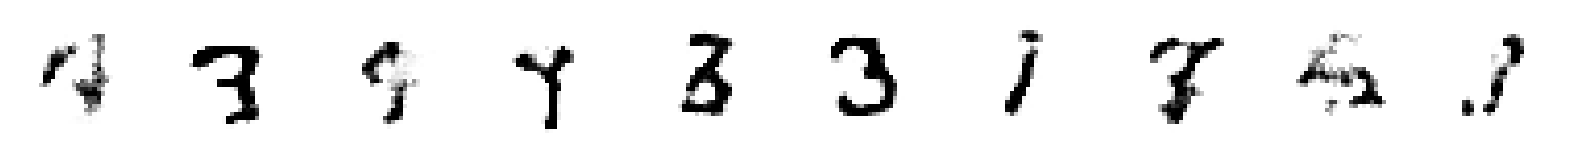

469/469 [==============================] - 558s 1s/step - loss: 2.7000e-04 - reg: 2.9776e-04 - cdiv: -2.7762e-05 - real: 0.0011 - fake: 0.0011 - val_cdiv: -4.0619 - val_real: 0.0140 - val_fake: -4.0479
Epoch 12/60
231/469 [=============>................] - ETA: 4:32 - loss: -2.7119e-05 - reg: 4.2757e-04 - cdiv: -4.5469e-04 - real: 0.0010 - fake: 5.8764e-04

In [ ]:
ebm.fit(
    x_train,
    shuffle=True,
    epochs=60,
    validation_data=x_test,
    callbacks=[
        save_model_callback,
        tensorboard_callback,
        image_generator_callback,
    ],
)

## 4. Generate images <a name="generate"></a>

In [ ]:
start_imgs = (
    np.random.uniform(size=(10, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)) * 2 - 1
)

In [ ]:
display(start_imgs)

In [ ]:
gen_img = generate_samples(
    ebm.model,
    start_imgs,
    steps=1000,
    step_size=STEP_SIZE,
    noise=NOISE,
    return_img_per_step=True,
)

In [ ]:
display(gen_img[-1].numpy())

In [ ]:
imgs = []
for i in [0, 1, 3, 5, 10, 30, 50, 100, 300, 999]:
    imgs.append(gen_img[i].numpy()[6])

display(np.array(imgs))